# CMS Open Data + Machine Learning
This notebook will take simulated and reconstructed proton-proton collision events from the 2011 CMS Open Data release and build a classifier for differentiating boosted, merged W boson jets from QCD jets. 
## Loading libraries
First we load the relevant libraries.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Input, Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Loading numpy arrays
Now we load two different numpy outputs. One corresponding to a sample of boosted, merged W->qq jets reconstructed from ttbar+jets simulation and one corresponding to QCD jets.

In [4]:
!cp -r /uscms_data/d3/jduarte1/DSHEP2017/CMSSW_5_3_32/src/2011-jet-inclusivecrosssection-ntupleproduction-optimized/AnalysisFW/python/output_* .

In [5]:
# get input numpy arrays
inputs = {}
inputs['TT'] = glob.glob('/eos/uscms/store/user/woodson/DSHEP2017/CMS_MonteCarlo2011_Summer11LegDR_TT_*/*job5*.npy')
inputs['QCD120'] = glob.glob('/eos/uscms/store/user/woodson/DSHEP2017/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-120to170_*/*job0*.npy')
inputs['QCD170'] = glob.glob('/eos/uscms/store/user/woodson/DSHEP2017/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-170to300_*/*job0*.npy')
inputs['QCD300'] = glob.glob('/eos/uscms/store/user/woodson/DSHEP2017/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-300to470_*/*job0*.npy')
inputs['QCD470'] = glob.glob('/eos/uscms/store/user/woodson/DSHEP2017/CMS_MonteCarlo2011_Summer11LegDR_QCD_Pt-470to600_*/*job0*.npy')

list_params = {}
params = {}
for key, input_files in inputs.iteritems():
    list_params[key] = []
    for in_file in input_files:
        try:
            arr = np.load(in_file)
            list_params[key].append(arr)
        except ValueError:
            print 'bad file: %s'%in_file
    params[key] = np.concatenate(list_params[key])

## Convert to Pandas DataFrame
Now we can convert the numpy arrays to data frames. First we can look at the features that are available. We can see that we have event-level information (`run`, `lumi`, `event`, `njet_ak7`, `pthat`), jet-level information (`jet_pt_ak7`, `jet_eta_ak7`, `jet_phi_ak7`, `jet_E_ak7`, `jet_msd_ak7`, `jet_area_ak7`, `jet_jes_ak7`, `jet_tau21_ak7`, `jet_isW_ak7`), and finally PF-candidate-level information (`ak7pfcand_pt`, `ak7pfcand_eta`, `ak7pfcand_phi`, `ak7pfcand_id`, `ak7pfcand_charge`, `ak7pfcand_ijet`). 

To start with, we'll just take the most relevant jet-level information as inputs (`jet_pt_ak7`, `jet_tau21_ak7`, `jet_msd_ak7`, `jet_ncand_ak7`) to try to predict whether the jet is a real boosted, merged W boson, which is given by the boolean `jet_isW_ak7` (The generator-level matching criteria is that a generated W boson which decays to qq is within the jet cone of 0.7 and the deltaR between the daughters is less than 0.7).

In [6]:
# convert to pandas dataframe
df_dict = {}
print params['TT'].dtype.names
df_dict['TT'] = pd.DataFrame(params['TT'],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'pthat','mcweight'])
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = pd.DataFrame(params[QCDbin],columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7', 'pthat','mcweight'])

df_dict['TT'] = df_dict['TT'].drop_duplicates()
df_dict['TT'] =  df_dict['TT'][(df_dict['TT'].jet_pt_ak7 > 200) & (df_dict['TT'].jet_pt_ak7 < 500) &  (df_dict['TT'].jet_isW_ak7==1)]

print 'number of W jets: %i'%len(df_dict['TT'])

for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin] = df_dict[QCDbin].drop_duplicates()
    df_dict[QCDbin] =  df_dict[QCDbin][(df_dict[QCDbin].jet_pt_ak7 > 200) & (df_dict[QCDbin].jet_pt_ak7 < 500) & (df_dict[QCDbin].jet_isW_ak7==0)]
    # take every 20th jet just to make the training faster and have a sample roughly the size of W jets
    df_dict[QCDbin] = df_dict[QCDbin].iloc[::20, :]
    
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    print 'number of QCD jets in bin %s: %i'%( QCDbin, len(df_dict[QCDbin]))

    
df_dict['QCD'] = pd.concat([df_dict['QCD120'],df_dict['QCD170'],df_dict['QCD300'],df_dict['QCD470']])
df = pd.concat([df_dict['TT'],df_dict['QCD']])

print df_dict['TT'].iloc[:3]
print df_dict['QCD'].iloc[:3]

('run', 'lumi', 'event', 'met', 'sumet', 'rho', 'pthat', 'mcweight', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
number of W jets: 1185
number of QCD jets in bin QCD120: 24
number of QCD jets in bin QCD170: 392
number of QCD jets in bin QCD300: 770
number of QCD jets in bin QCD470: 391
      jet_pt_ak7  jet_tau21_ak7  jet_msd_ak7  jet_ncand_ak7  jet_isW_ak7  \
1394  254.051069       0.134433    90.338424             36            1   
4470  337.504360       0.325908    90.002093             64            1   
5974  330.677864       0.308630    82.549370             67            1   

      pthat    mcweight  
1394    0.0  147.332993  
4470    0.0  147.332993  
5974    0.0  147.332993  
        jet_pt_ak7  jet_tau21_ak7  jet_msd_ak7  jet_ncand_ak7  jet_isW_ak7  \
69

## Plotting inputs
Let's make some plots of the inputs for both W and QCD jets, specifically the soft-drop mass `jet_msd_ak7` and the n-subjettiness substructure variable`jet_tau21_ak7`.

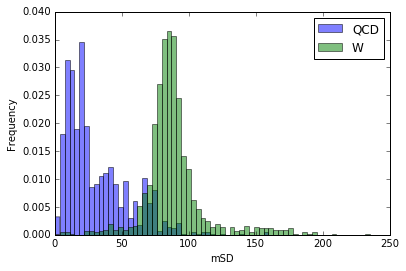

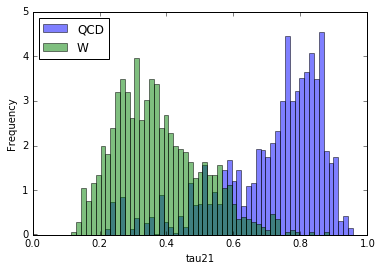

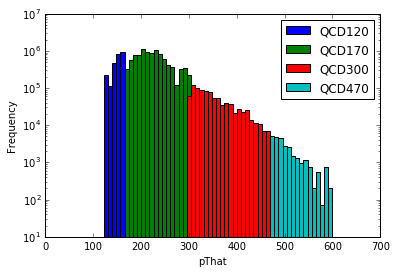

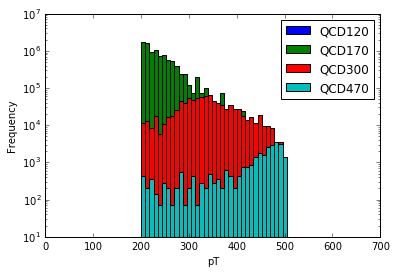

In [7]:
%matplotlib inline
plt.figure()
plt.xlabel('mSD')
bins = np.linspace(0, 250, 70)
df_dict['QCD']['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='QCD', weights=df_dict['QCD']['mcweight'],normed=True)
df_dict['TT']['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel('tau21')
bins = np.linspace(0, 1, 70)
df_dict['QCD']['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='QCD',weights=df_dict['QCD']['mcweight'],normed=True)
df_dict['TT']['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper left')
plt.figure()
plt.xlabel('pThat')
bins = np.linspace(0, 600, 70)
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin]['pthat'].plot.hist(bins, alpha=1, label=QCDbin, weights=df_dict[QCDbin]['mcweight'], stacked=True, log=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel('pT')
bins = np.linspace(0, 600, 70)
for QCDbin in ['QCD120','QCD170','QCD300','QCD470']:
    df_dict[QCDbin]['jet_pt_ak7'].plot.hist(bins, alpha=1, label=QCDbin, weights=df_dict[QCDbin]['mcweight'], stacked=True, log=True)
plt.legend(loc='upper right')

## Defining our model (neural net topology)
We'll start with the classic densely-connected NN layer. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to class values (0 or 1).

Finally, we are using the logarithmic loss function (`binary_crossentropy`) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [30]:
# baseline model
NDIM = 4
def create_baseline():
    # This returns a tensor
    inputs = Input(shape=(NDIM,))
    # a layer instance is callable on a tensor, and returns a tensor
    #x = Dense(NDIM, init='glorot_uniform', activation='relu')(inputs)
    #predictions = Dense(1, init='glorot_uniform', activation='sigmoid')(x)
    
    x = Dense(NDIM, init='normal', activation='relu')(inputs)
    predictions = Dense(1, init='normal', activation='sigmoid')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(input=inputs, output=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


    # create model with Sequential
    #model = Sequential()
    # this works for keras 2.0.3
    #model.add(Dense(NDIM, input_dim=NDIM, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # this works for keras 1.2.2 (CMSSW_9_0_1)
    #model.add(Dense(NDIM, init='normal', input_dim=NDIM, activation='relu'))
    #model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #return model
model = create_baseline()
model.summary()
# visalize model
#from keras.utils.visualize_util import plot
#plot(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 4)             0                                            
____________________________________________________________________________________________________
dense_37 (Dense)                 (None, 4)             20          input_19[0][0]                   
____________________________________________________________________________________________________
dense_38 (Dense)                 (None, 1)             5           dense_37[0][0]                   
Total params: 25
Trainable params: 25
Non-trainable params: 0
____________________________________________________________________________________________________


## Cross validation
Now we can evaluate this model using stratified cross validation in the scikit-learn framework.

We pass the number of training epochs to the KerasClassifier, again using reasonable default values. Verbose output is also turned off given that the model will be created 3 times for the 3-fold cross validation being performed.

Running this code produces the following output showing the mean and standard deviation of the estimated accuracy of the model on unseen data.

In [21]:
dataset = df.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

print 1.*sum(encoded_Y)/len(encoded_Y)

# evaluate baseline model
# this works for keras 2.0.3
#estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# this works for keras 1.2.2 (CMSSW_9_0_1)
#estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
for (train, test) in kfold.split(X, encoded_Y):
    print 1.*sum(encoded_Y[train])/len(encoded_Y[train])
    print 1.*sum(encoded_Y[test])/len(encoded_Y[train])
    
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
#print "Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)

0.429036929761
0.428985507246
0.429710144928
0.429088277858
0.428364688857


## Visualize performance with ROC curves
Here, we visualize the performance of our model with a ROC curve for each cross validation sample.

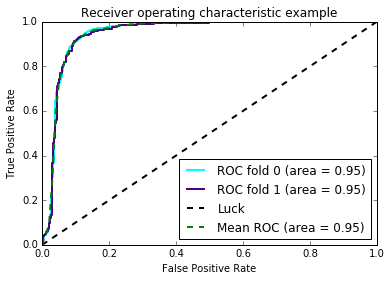

In [32]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    model = create_baseline()
    history = model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=100, batch_size=100, verbose=0, callbacks=[early_stopping])
    Y_score = model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


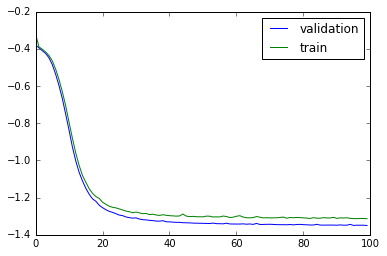

In [33]:
val_loss = np.asarray(histories[0].history['val_loss'])
loss = np.asarray(histories[0].history['loss'])
plt.plot(np.log(val_loss), label='validation')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.show()

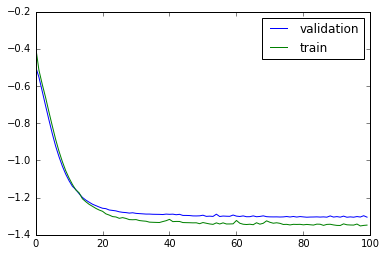

In [34]:
val_loss = np.asarray(histories[1].history['val_loss'])
loss = np.asarray(histories[1].history['loss'])
plt.plot(np.log(val_loss), label='validation')
plt.plot(np.log(loss), label='train')
plt.legend()
plt.show()

In [94]:
print histories

[<keras.callbacks.History object at 0x7fc2a2eba9d0>, <keras.callbacks.History object at 0x7fc2a2e6bcd0>]
